In [5]:
from tensorflow.keras.models import load_model

model = load_model('content/resnet50.hdf5')

In [6]:
from tensorflow.keras.models import Model
model= Model(inputs=model.input, outputs=model.layers[-2].output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
import os
path_to_fonts = 'font'
filelist = []
for root, dirs, files in os.walk(path_to_fonts): 
    for file in files: 
        filelist.append(file)

In [14]:
filelist = filelist[:1]

In [15]:
import numpy as np
from PIL import Image
path_to_fonts = 'img'
X_data = []
Y_data=[]
#fontlist=[]
for root, dirs, files in os.walk(path_to_fonts): 
    for file in files: 
        for font in filelist:
            if(font in file and '30' in file):
                X_data.append(np.asarray(Image.open(os.path.join(root,file))).astype('int8'))
                Y_data.append(os.path.join(root,file)[4:5])

In [16]:
X_data = np.array(X_data)

In [17]:
Y_data[100]

'亟'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


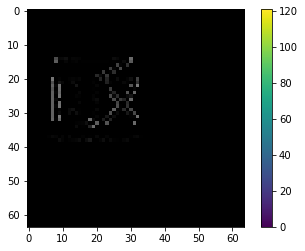

In [18]:
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(X_data[100])
plt.colorbar()
plt.grid(False)
plt.show()

In [19]:
result_vector_embedding = model(X_data)

print(np.shape(result_vector_embedding))

(8184, 2048)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout

In [21]:
hidden_dim = 1000
batch_size = 44 
 
def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

In [22]:
#энкодер
input_img = Input((2048))
x = Dense(256, activation='relu')(input_img)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)
#Вектор z_mean – это МО, а вектор z_log_var – логарифм дисперсий  
z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

In [23]:
def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  return K.exp(z_log_var / 2) * N + z_mean

In [24]:
h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

In [25]:
input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(input_dec)
d = dropout_and_batch(d)
decoded = Dense(2048, activation='sigmoid')(d)

In [26]:
encoder = Model(input_img, h, name='encoder')
decoder = Model(input_dec, decoded, name='decoder')
vae = Model(input_img, decoder(encoder(input_img)), name="vae")
z_meaner = Model(input_img, z_mean, name='Enc_z_mean')
z_lvarer = Model(input_img, z_log_var, name='Enc_z_log_var')

In [27]:
def vae_loss(x, y):
  x = K.reshape(x, shape=(batch_size, 2048))
  y = K.reshape(y, shape=(batch_size, 2048))
  # первый критерий – разница между входным и выходным сигналами
  loss = abs(2048*binary_crossentropy(x, y))
  #вычисление второго критерия – расстояния Кульбака-Лейблера по тензорам z_mean и z_log_var.  
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return (loss + kl_loss)/2/2048

In [28]:
vae.compile(optimizer='adam', loss=vae_loss)

In [29]:
vae.fit(result_vector_embedding, result_vector_embedding, epochs=150, batch_size=batch_size, shuffle=True)

Epoch 1/150
186/186 [==============================] - 2s 11ms/step - loss: 0.1262
Epoch 2/150
186/186 [==============================] - 2s 12ms/step - loss: 0.0685
Epoch 3/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0579
Epoch 4/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0515
Epoch 5/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0456
Epoch 6/150
186/186 [==============================] - 2s 12ms/step - loss: 0.0410
Epoch 7/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0372
Epoch 8/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0342
Epoch 9/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0318
Epoch 10/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0296
Epoch 11/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0273
Epoch 12/150
186/186 [==============================] - 2s 11ms/step - loss: 0.0252
E

In [30]:
X_encode = z_meaner.predict(result_vector_embedding, batch_size=batch_size)

In [31]:
from sklearn.manifold import TSNE

p_field = TSNE().fit_transform(X_encode)

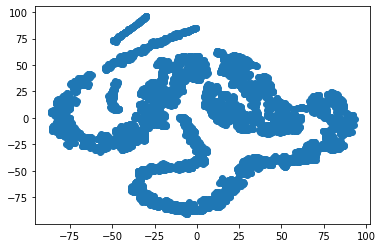

In [32]:
#скрытый слой
plt.scatter(p_field[:, 0], p_field[:, 1])

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(X_encode)

In [64]:
def get_indices(lst, el):
    return [i for i in range(len(lst)) if lst[i] == el]
indeces = get_indices(kmeans.labels_, 0)

In [65]:
for indece in indeces:
    print(Y_data[indece])

α
γ
δ
丁
丈
丸
久
亏
互
亓
井
亨
亩
亹
亿
仃
从
仚
仞
仪
仰
仲
企
伢
伥
伦
估
伴
位
住
佤
佫
佴
併
侂
依
俉
俗
俚
俩
俳
俾
倓
倞
倡
傍
傻
僭
僴
僾
允
兄
先
党
六
兼
兽
冬
决
冶
减
凑
凯
刃
划
剐
办
加
劣
勖
化
匦
千
卍
卫
厅
厓
厶
及
叧
史
司
君
吟
听
呃
呔
呙
咀
咋
咛
咟
咩
响
哐
哪
哲
哴
哺
哼
唁
唆
唇
唉
唛
唠
唱
唿
啃
啐
啤
啥
啧
啶
善
喫
喵
嗙
嗟
嗳
嗵
嗼
嗾
嘁
嘛
噍
噫
噹
囥
囷
圫
圳
圹
均
坍
坞
坪
坼
垌
垠
埆
埇
埭
堠
堺
塙
填
墅
壵
壶
壻
备
夏
夕
外
奂
奢
妊
妬
妯
妾
姑
姮
娈
娠
媺
嫄
嫋
嫖
嬖
嬴
孑
孖
孳
宀
宁
宕
宠
审
宬
宵
寇
富
寡
尥
尪
尴
尸
层
展
岔
岡
峰
峻
嶒
嶲
嶽
师
帔
幛
并
幺
庵
庼
庾
开
弦
弶
弼
彊
彐
徇
得
御
徵
忭
忽
急
恋
恤
恧
恻
悬
悭
悯
惋
惟
愈
慄
慝
戏
戛
扁
扇
扌
扣
抑
抬
押
拥
拧
拱
挈
按
挣
挽
捌
捏
据
掂
掘
掴
揿
搞
摘
撅
撚
撞
攀
攒
攥
放
敝
敞
敦
敫
敬
敷
文
斗
料
斟
斯
方
於
旁
旒
旗
日
旦
旮
昉
晞
晡
普
晳
暑
暗
暲
暹
朗
末
朴
朽
杀
杆
杈
村
杠
杮
杵
杼
板
构
枒
枓
枕
枯
枰
柠
柱
栋
校
栫
案
桢
桦
梧
梿
棕
棹
棺
椑
椽
楠
楮
榅
榫
榴
槜
樋
樟
橑
橞
橼
檐
檩
櫈
次
欢
欧
歃
歙
此
殇
殒
殖
殛
气
氚
氩
氮
氽
汁
汙
污
汤
汫
汾
沅
沉
沌
沪
沰
河
沸
泓
泠
注
泯
泳
泷
洑
洧
洨
洵
洹
洼
浈
浊
浏
浓
浙
浚
浞
浪
浯
涛
涡
润
涯
涰
液
涶
淖
淝
淞
淤
淦
淬
淮
淹
渎
渐
渢
渺
湟
湶
湿
源
溥
溴
溹
溻
滆
滘
滞
滥
滦
滪
漉
漏
漯
漱
漶
潄
潋
潼
澍
澎
澥
激
濉
火
灿
炀
炆
炳
烔
烙
烚
焐
煜
熕
燏
爀
牛
牝
牡
牯
牴
牾
状
狈
狠
狼
猄
猊
玑
玓
玖
玗
玠
玡
玦
玮
玳
珠
珩
珮
琪
琯
琰
瑁
瑞
瑠
璆
璐
璜
璟
瓒
瓜
瓣
瓦
瓶
画
畁
畜
畸
疥
疫
疬
疱
疲
疴
疸
疽
症
痛
痢


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


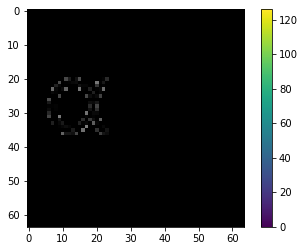

In [36]:
plt.figure()
plt.imshow(X_data[indeces[0]])
plt.colorbar()
plt.grid(False)
plt.show()

In [47]:
from PIL import ImageChops
import math, operator
from functools import reduce
def rmsdiff(im1, im2):
    "Calculate the root-mean-square difference between two images"

    h = ImageChops.difference(im1, im2).histogram()

    # calculate rms
    return math.sqrt(reduce(operator.add,
        map(lambda h, i: h*(i**2), h, range(256))
    ) / (float(im1.size[0]) * im1.size[1]))

In [42]:
from PIL import Image
path_to_fonts = 'img'
X_data_test = []
for root, dirs, files in os.walk(path_to_fonts): 
    for file in files: 
        for font in filelist:
            if(font in file and '30' in file):
                X_data_test.append(Image.open(os.path.join(root,file)))

In [71]:
from sklearn.metrics import mean_squared_error
#summ = 0
for lable in range(10):
    indeces = get_indices(kmeans.labels_, lable)
    summ_ind = 0
    for i in range(len(indeces)):
        for j in range(i+1, len(indeces)):
            summ_ind = summ_ind + rmsdiff(X_data_test[indeces[i]], X_data_test[indeces[j]])
    print("в кластере " + str(lable) + " растояние между " + str(len(indeces)) + " иероглифами " + str(summ_ind))

в кластере 0 растояние между 861 иероглифами 24627619.49802934
в кластере 1 растояние между 1102 иероглифами 40639439.71401044
в кластере 2 растояние между 1084 иероглифами 39189947.584733464
в кластере 3 растояние между 727 иероглифами 17687748.83316873
в кластере 4 растояние между 1158 иероглифами 44840363.84596485
в кластере 5 растояние между 181 иероглифами 1070779.3530345864
в кластере 6 растояние между 1000 иероглифами 33412821.21187805
в кластере 7 растояние между 587 иероглифами 11393443.470595779
в кластере 8 растояние между 217 иероглифами 1563420.8836128975
в кластере 9 растояние между 1267 иероглифами 53647320.011301145


In [72]:
#summ = 0
lable = 0
from sklearn import utils
for X_array in np.array_split(utils.shuffle(X_data_test), 10):
    rms_lable = 0
   # print("идет работа с кластером " + str(lable) + " " + str(summ))
    #summ_ind = 0
    for i in range(len(X_array)):
        for j in range(i+1,len(X_array)):
            rms_lable = rms_lable + rmsdiff(X_array[i], X_array[j])
    print("в кластере " + str(lable) + " растояние между " + str(len(X_array)) + " иероглифами " + str(rms_lable))
    lable = lable + 1

в кластере 0 растояние между 819 иероглифами 22391789.93753253
в кластере 1 растояние между 819 иероглифами 22362396.81822122
в кластере 2 растояние между 819 иероглифами 22326186.68747913
в кластере 3 растояние между 819 иероглифами 22398292.900058318
в кластере 4 растояние между 818 иероглифами 22307560.89963723
в кластере 5 растояние между 818 иероглифами 22305920.60040963
в кластере 6 растояние между 818 иероглифами 22323229.93200398
в кластере 7 растояние между 818 иероглифами 22341806.37930896
в кластере 8 растояние между 818 иероглифами 22375296.133906554
в кластере 9 растояние между 818 иероглифами 22375995.477952268
